In [14]:
% matplotlib inline 

import h5py, sys, io, numpy as np
import nibabel as nib
import nibabel.gifti
import nilearn
from nilearn import datasets, plotting
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mpl.rcParams['svg.fonttype'] = 'none'

In [111]:
def imageCrop(filename):

    from PIL import Image

    i1 = Image.open(filename)
    i2 = np.array(i1)
    i2[i2.sum(axis=2) == 255*4,:] = 0
    i3 = i2.sum(axis=2)
    x = np.where((i3.sum(axis=1) != 0) * 1)[0]
    y = np.where((i3.sum(axis=0) != 0) * 1)[0]

    result = Image.fromarray(i2[x.squeeze()][:,y.squeeze()])
    result.save(filename)

In [15]:
surfmL = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.L.midthickness.32k_fs_LR.surf')
surfiL = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.L.very_inflated.32k_fs_LR.surf')
surfL = []
surfL.append(np.array(surfmL[0]*0.3 + surfiL[0]*0.7))
surfL.append(surfmL[1])

surfmR = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.R.midthickness.32k_fs_LR.surf')
surfiR = nib.freesurfer.read_geometry('gradient_data/templates/Q1-Q6_R440.R.very_inflated.32k_fs_LR.surf')
surfR = []
surfR.append(np.array(surfmR[0]*0.3 + surfiR[0]*0.7))
surfR.append(surfmR[1])

sulcL = -1 * nib.load('gradient_data/templates/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii').data[0:32492]
sulcR = -1 * nib.load('gradient_data/templates/Q1-Q6_R440.sulc.32k_fs_LR.dscalar.nii').data[32492:32492*2]

res = nib.load('gradient_data/templates/hcp.tmp.lh.dscalar.nii').data
cortL = np.squeeze(np.array(np.where(res != 0)[0], dtype=np.int32))
res = nib.load('gradient_data/templates/hcp.tmp.rh.dscalar.nii').data
cortR = np.squeeze(np.array(np.where(res != 0)[0], dtype=np.int32))
cortLen = len(cortL) + len(cortR)
del res

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [16]:
emb = np.load('gradient_data/embedded/embedding_dense_emb.npy')

## Yeo7 networks 

In [113]:
yeo7L = nib.gifti.read('gradient_data/templates/hcp.RSN.L.gii').darrays[0].data
yeo7R = nib.gifti.read('gradient_data/templates/hcp.RSN.R.gii').darrays[0].data
yeo17L = nib.gifti.read('gradient_data/templates/hcp.RSN.L.gii').darrays[1].data
yeo17R = nib.gifti.read('gradient_data/templates/hcp.RSN.R.gii').darrays[1].data

In [114]:
yeo7 = np.concatenate((yeo7L[cortL], yeo7L[cortR]))
uniqueY = np.array(np.unique(yeo7), dtype=np.int32)[1::]
sz = len(uniqueY)
rsns={}
for c in range(sz):
    rsns['k'+str(int(c)+1)]=[]

r = []     
for x in range(sz):
    g = emb[np.where(yeo7 == uniqueY[x]),0]
    for y in g[0]:
        if y != 0:
            rsns['k'+str(int(x)+1)].append(float(y))
    r.append(np.mean(rsns['k'+str(int(x)+1)]))

ord = np.argsort(r)

plot_list=[]
for c in range(sz):    
    plot_list+=[np.squeeze(rsns['k'+str(ord[c]+1)])]

names=[]
for c in range(sz):
    names.append(str(int(ord[c])+1))

convertYeo7 = [2,5,6,0,4,1,3] 
cols7 = ((255,255,255),
         (120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (220 ,248 ,164),
         (230, 148,  34),
         (205 , 62,  78 ))
cols = cols7
cols = np.asarray(cols, dtype=float)/255
yeoCols = ListedColormap(cols,name='colormapYeo')

colors1 = list()
for i in xrange(0,len(ord)):
    colors1.append(tuple(cols[convertYeo7[ord[i]] + 1]))

In [115]:
height=10
sns.set_context('notebook', font_scale=1.8)
sns.axes_style("white")
sns.set_style("white")
sns.set_palette(colors1)

fig = plt.figure(figsize=(20,height))
ax = sns.boxplot(data=plot_list, saturation=0.5, orient='h', showfliers=False) #flierprops=None)#dict(marker='', markersize=0, 
                                                                               #color="white", markeredgecolor="white"))
ax.set_yticklabels('')
sns.axes_style("white")
sns.axlabel('Gradient Values','', fontsize=22)
plt.savefig('gradient_data/figures/yeo_dist_plot.pdf')
plt.savefig('gradient_data/figures/yeo_dist_plot.png')
plt.close(fig)

fig, axarr = plt.subplots(nrows=sz, ncols=1, figsize=(2*(20/sz),height))
data = datasets.fetch_atlas_yeo_2011(data_dir='gradient_data/templates/')
yeoV7 = nibabel.load(data.thick_7)
y = 0
for x in range(sz):
    yeoV7_1 = nibabel.Nifti1Image((yeoV7.get_data() == convertYeo7[ord[x]] + 1).astype(int), yeoV7.get_affine())     
    yeoCols = ListedColormap(cols[[0,convertYeo7[ord[x]] + 1]],name='colormapYeo')
    plotting.plot_glass_brain(yeoV7_1, axes=axarr[x], annotate=False, alpha=0.3, cmap=yeoCols, threshold=0.1, 
                          output_file='gradient_data/figures/yeo_brains.png')
    y += 1

from PIL import Image
i1 = Image.open('gradient_data/figures/yeo_dist_plot.png')
i2 = Image.open('gradient_data/figures/yeo_brains.png')
result = Image.new("RGBA", (np.shape(i1)[1]+50, np.shape(i1)[0]))
result.paste(i1, (120, 0))
result.paste(i2, (0, 0))
result.save('gradient_data/figures/Yeo7_Fig.png')

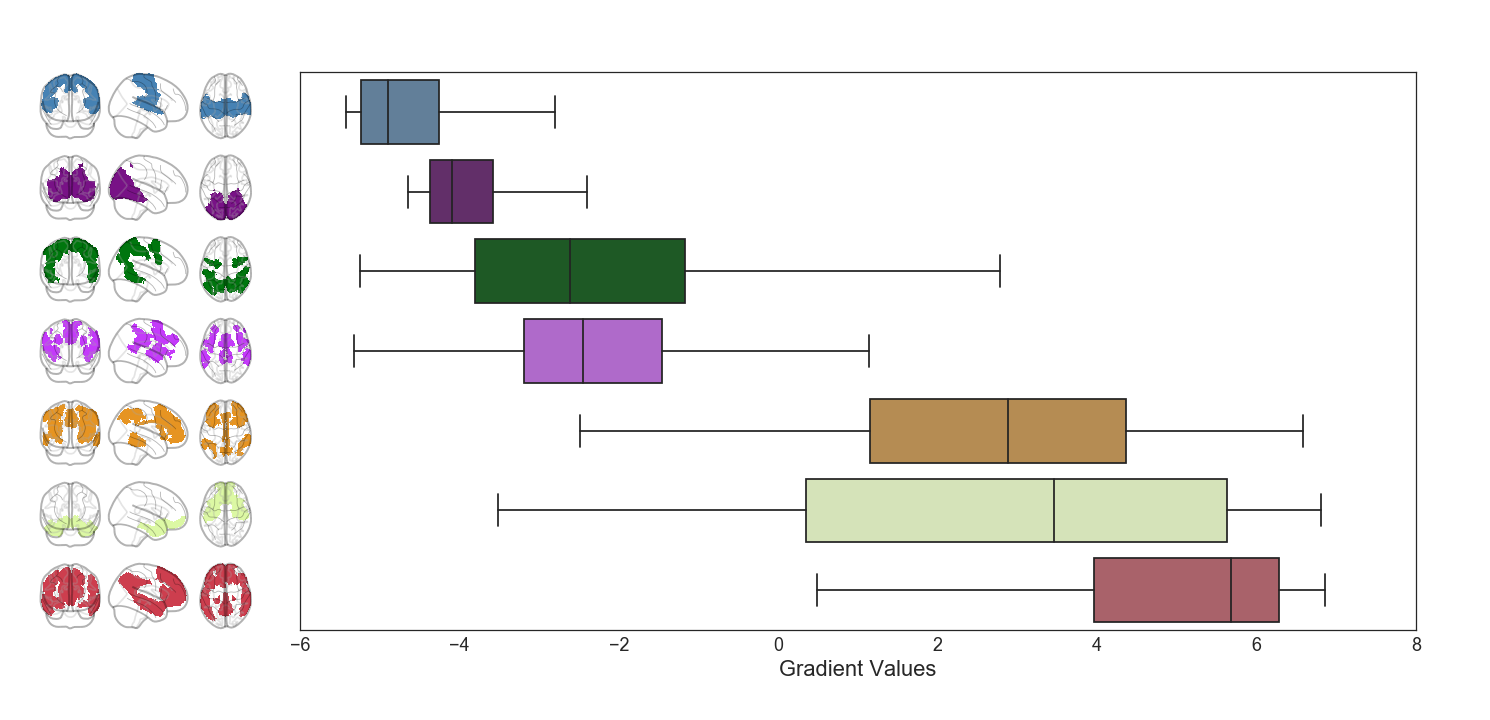

In [116]:
from IPython.display import Image as im
im(filename='gradient_data/figures/Yeo7_Fig.png') 

In [35]:
import sys
sys.path.append('gradient_data/src/')
from viz import *

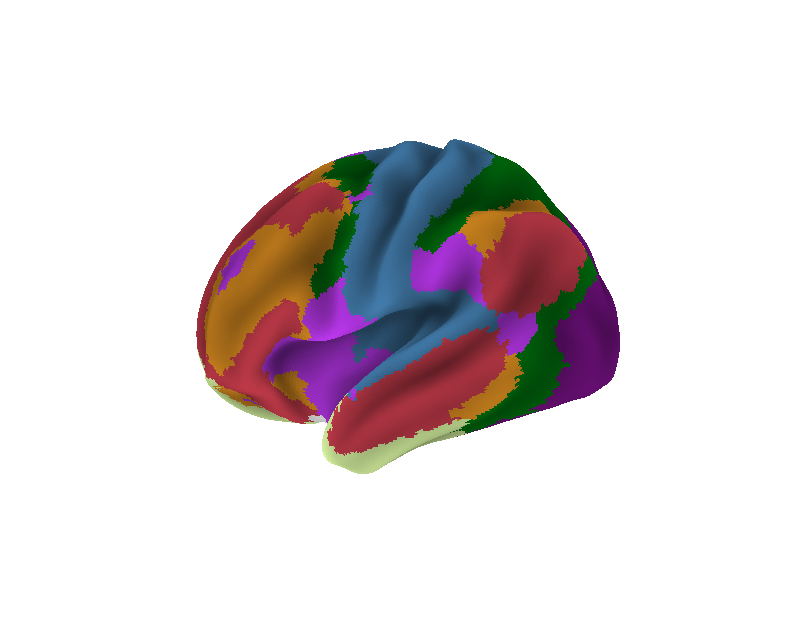

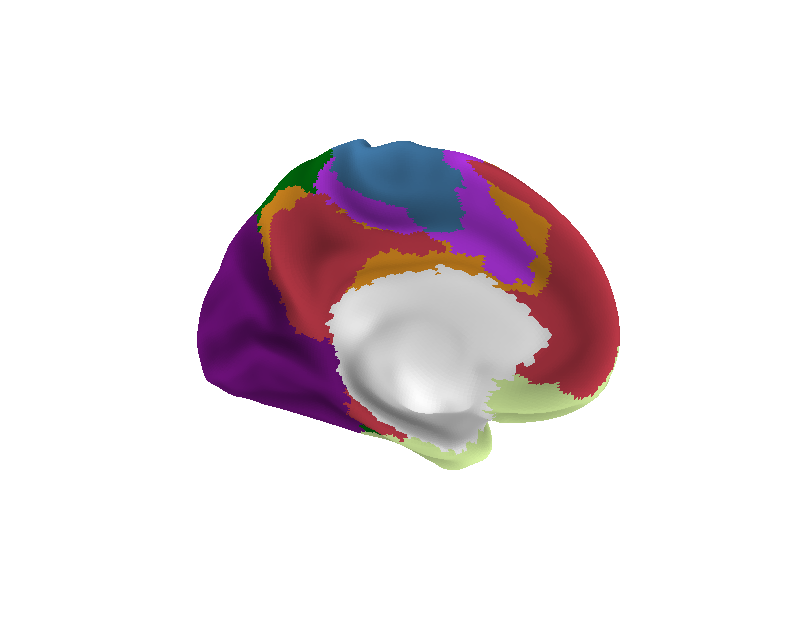

In [36]:
cols7 = ((255,255,255),
         (120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (220 ,248 ,164),
         (230, 148,  34),
         (205 , 62,  78 ))
cols = cols7
cols = np.asarray(cols, dtype=float)/255
yeoCols = ListedColormap(cols,name='colormapYeo')
y = yeo7L.copy()
for n, v in enumerate(uniqueY):
    y[yeo7L == v] = int(convertYeo7[n]) - 3
y[yeo7L == 37] = - 4
c = np.where([yeo17L != 37])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, bg_on_stat=True, stat_map=y, azim=0, alpha=1, cmap=yeoCols, label=True, 
                       bg_scaling_factor=1.5)
plt.show()
f.savefig('gradient_data/figures/yeo7.lat.png')
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, bg_on_stat=True, stat_map=y, azim=180, alpha=1, cmap=yeoCols, label=True, 
                       bg_scaling_factor=1.5)
plt.show()
f.savefig('gradient_data/figures/yeo7.med.png')

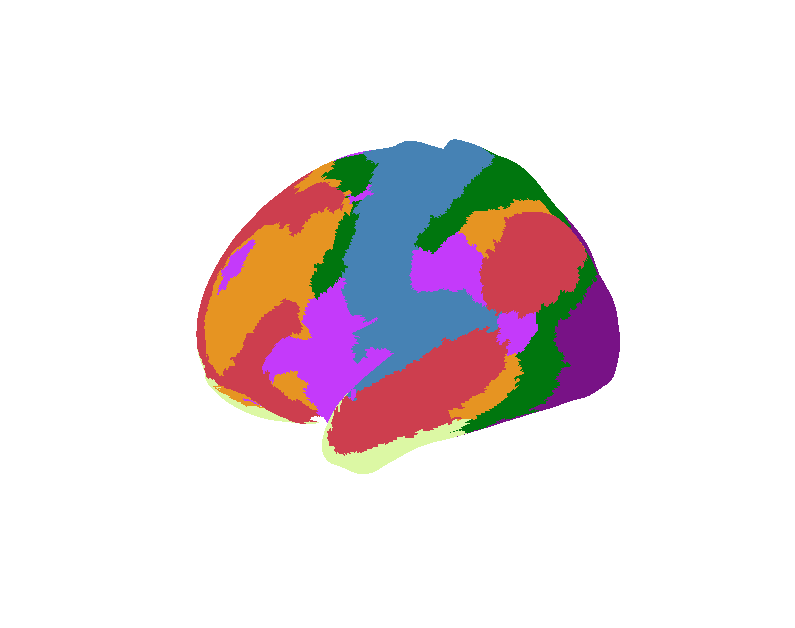

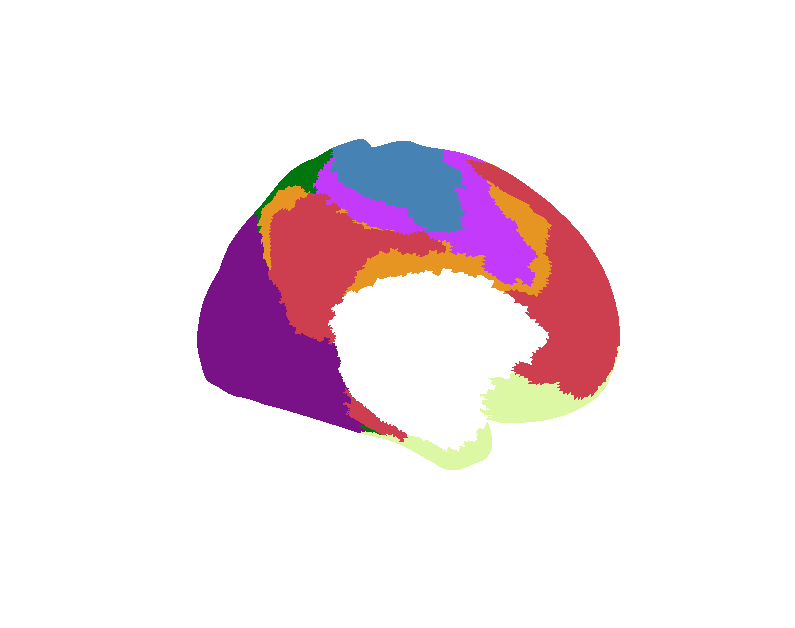

In [174]:
cols7 = ((255,255,255),
         (120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (220 ,248 ,164),
         (230, 148,  34),
         (205 , 62,  78 ))
cols = cols7
cols = np.asarray(cols, dtype=float)/255
yeoCols = ListedColormap(cols,name='colormapYeo')
y = yeo7L.copy()
for n, v in enumerate(uniqueY):
    y[yeo7L == v] = int(convertYeo7[n]) - 3
y[yeo7L == 37] = - 4
c = np.where([yeo17L != 37])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, bg_on_stat=False, stat_map=y, azim=0, alpha=1, cmap=yeoCols, label=True)
fname = 'gradient_data/figures/yeo7.nobk.lat.png'
f.savefig(fname)
imageCrop(fname)
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, bg_on_stat=False, stat_map=y, azim=180, alpha=1, cmap=yeoCols, label=True)
plt.show()
fname = 'gradient_data/figures/yeo7.nobk.med.png'
f.savefig(fname)
imageCrop(fname)

In [117]:
cols = ((170,170,170),
         (120,  18, 134),
         (70 ,130, 180),
         ( 0 ,118 , 14),
         (196 , 58 ,250),
         (220 ,248 ,164),
         (230, 148,  34),
         (205 , 62,  78 ))
cols = np.asarray(cols, dtype=float)/255
a = np.squeeze([cols[i] for i in y])


TypeError: 'int' object is not iterable

In [24]:
import scipy.io
scipy.io.savemat('../topography/yeo7L.mat',{'a':a})

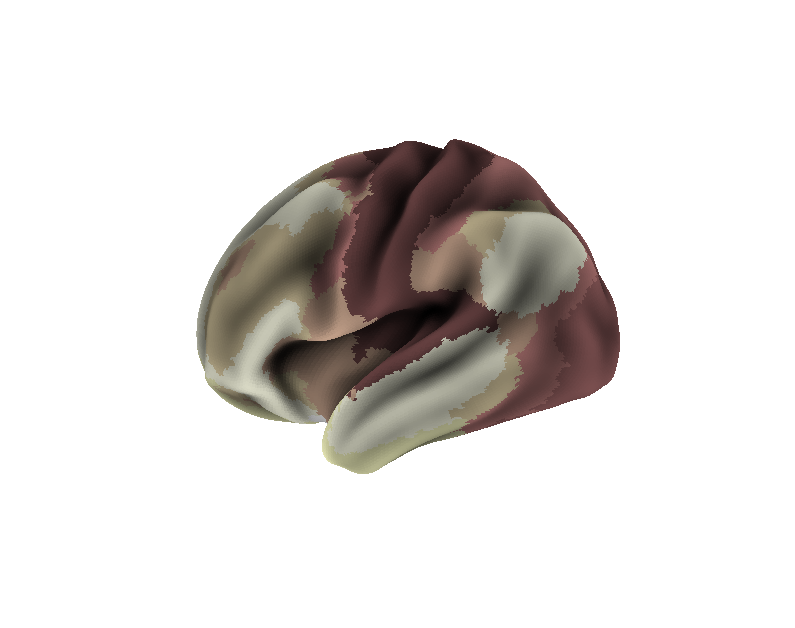

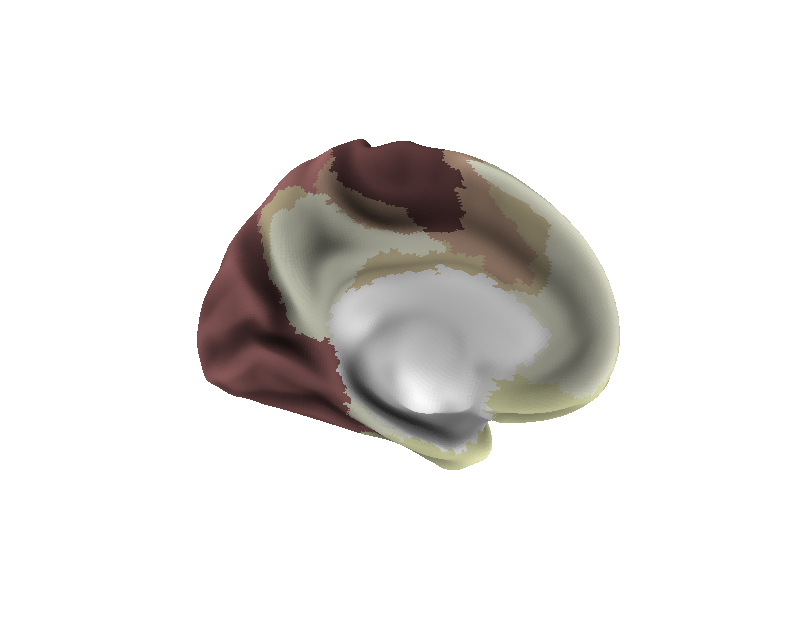

In [25]:
# plot order on surface
cmap='pink'
y = yeo7L.copy()
ord1 = np.argsort(ord)
for n, v in enumerate(uniqueY):
    y[yeo7L == v] = int(ord1[n]) + 1 - 4
y[yeo7L == 37] = -4
c = np.where([yeo17L != 37])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, cmap=cmap, mask=c, bg_on_stat=True, azim=0, alpha=1, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo7.reord.lat.png')
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, cmap=cmap, mask=c, bg_on_stat=True, azim=180, alpha=1, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo7.reord.med.png')

In [ ]:
import surfdist as sd
from surfdist import viz, load, utils, surfdist
vertices, triangles = utils.surf_keep_cortex(surfmL, cortL)

In [118]:
aL = []
z0 = yeo7L[surfL[1]][:,0]
z1 = yeo7L[surfL[1]][:,1]
z2 = yeo7L[surfL[1]][:,2]

for n,i in enumerate(z0):
    if i != z1[n]:
        aL.append(surfL[1][n])
    if i != z2[n]:
        aL.append(surfL[1][n])
    if z1[n] != z2[n]:
        aL.append(surfL[1][n])
aL = np.unique(aL)

import gdist
aLp = []
for i in aL:
    b = np.where(cortL == i)[0]
    if b:
        aLp.append(b)
aLp = np.array(aLp).flatten()    
distLs = gdist.compute_gdist(vertices, triangles, source_indices=np.array(aLp, dtype=np.int32))

In [119]:
distL = np.zeros(32492)
distL[cortL] = distLs

3546


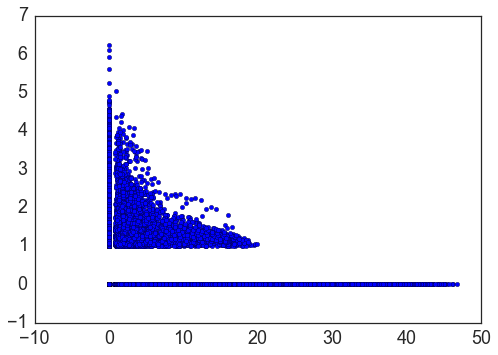

In [124]:
y = yeo7L.copy()
e = np.zeros(32492)
e[cortL] = emb[:len(cortL),0]
for n, v in enumerate(uniqueY):
    indx = np.where(yeo7L == v)[0]
    z = e[indx]
    zm = z - np.mean(z)    
    y[indx] = zm / np.std(zm)
y[yeo7L == 37] = 0
y[np.abs(y) < 1] = 0
print len(np.where(y > 0)[0])
plt.scatter(distL[incld],np.abs(y[incld]))
plt.show()

In [30]:
incld = np.where(surfiL[0][:,1] < 90)[0]

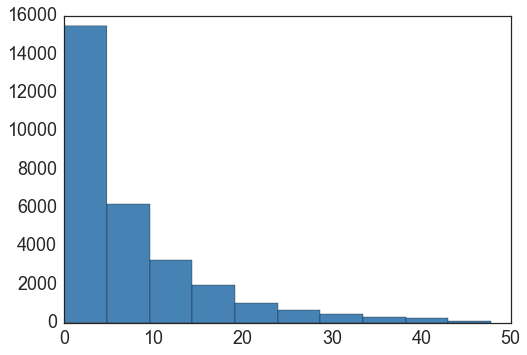

In [31]:
plt.hist(distL[cortL])
plt.show()

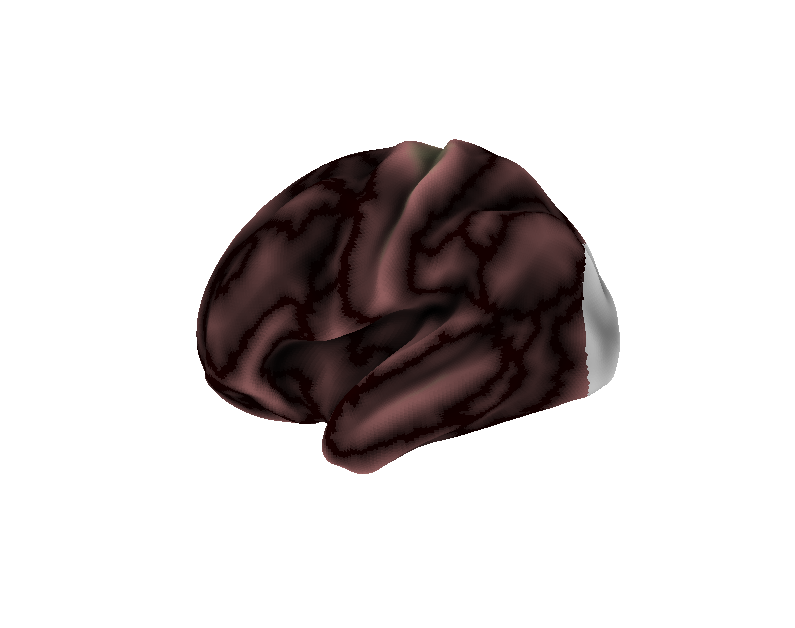

In [32]:
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=distL, cmap=cmap, mask=incld, bg_on_stat=True, azim=0, alpha=1, label=True)
plt.show()

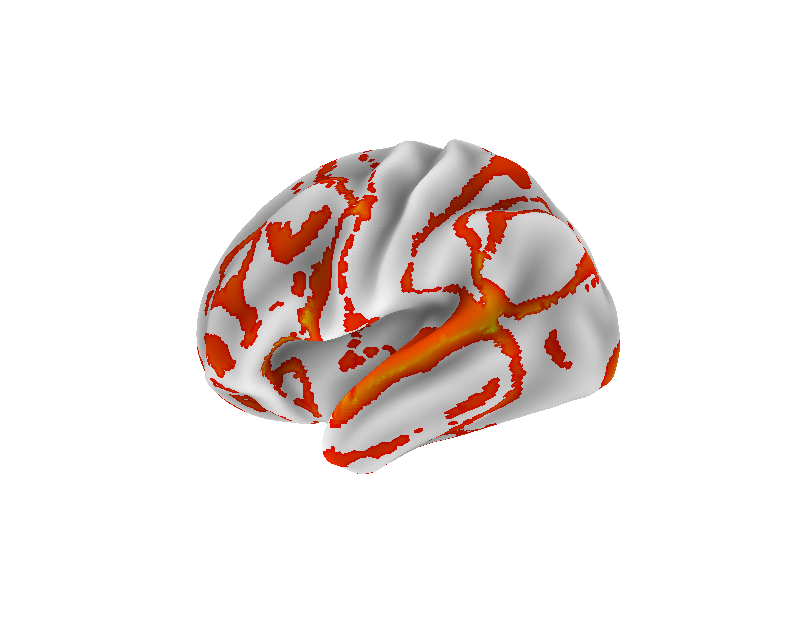

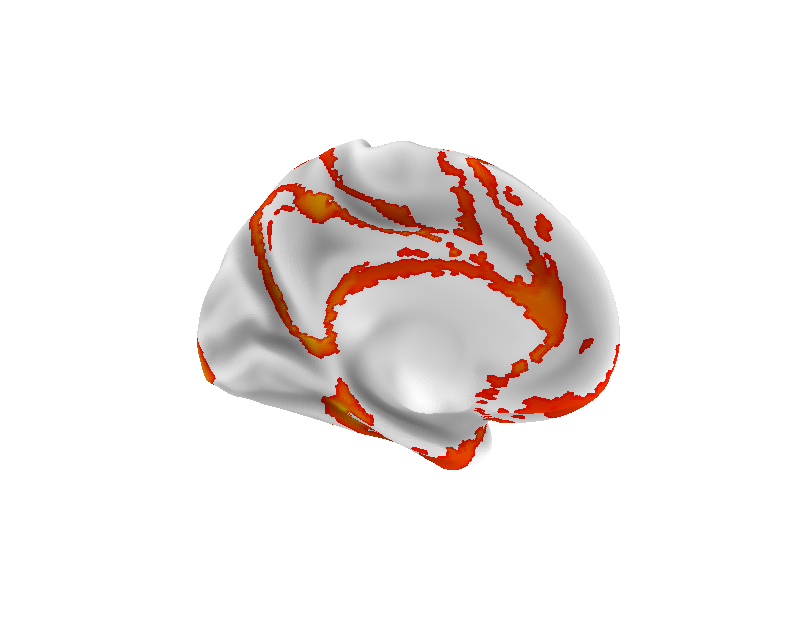

In [175]:
std_thr = 0
cmap='autumn'
import scipy.stats as stats

y = yeo7L.copy()
e = np.zeros(32492)
e[cortL] = emb[:len(cortL),0]
for n, v in enumerate(uniqueY):
    indx = np.where(yeo7L == v)[0]
    z = e[indx]
    # for percentile:
    #p = [stats.percentileofscore(z, a, 'rank') for a in z]
    #p = np.array(p)
    #p[np.where([(p1 > 25.0) & (p1 < 75.0) for p1 in p])] = 0
    #y[indx] = p
    
    zm = z - np.mean(z)      
    y[indx] = zm / np.std(zm)
        
y[np.abs(y) < 1.] = 0
y[yeo7L == 37] = 0
y = np.abs(y)

#y[y < std_thr] = 0
#y[aL] = 0 #std_thr * -1
#c = np.where([y > std_thr])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, cmap=cmap, mask=np.where(y != 0)[0], 
                       lenient=True, bg_on_stat=True, azim=0, alpha=1, label=False, 
                       symmetric_cbar = False, bg_scaling_factor=1.5)
plt.show()
fname = 'gradient_data/figures/yeo7.outliers.lat.png'
f.savefig(fname)
imageCrop(fname)

f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, cmap=cmap, mask=np.where(y != 0)[0], 
                       lenient=True, bg_on_stat=True, azim=180, alpha=1, label=False,
                       symmetric_cbar = False, bg_scaling_factor=1.5)
plt.show()
fname = 'gradient_data/figures/yeo7.outliers.med.png'
f.savefig(fname)
imageCrop(fname)

In [177]:
print np.min(y)

0.0


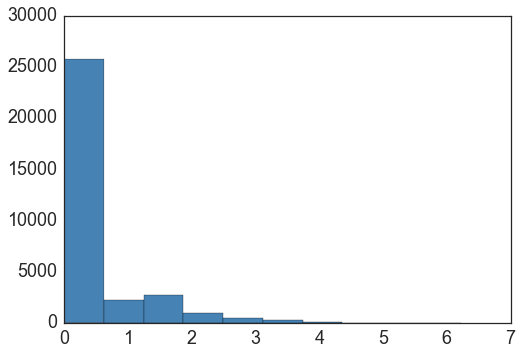

In [171]:
plt.hist(np.nonze(y))
plt.show()

In [92]:
a = [len(np.where(y == i)[0]) for i in np.unique(y)]
print a[1] + a[2]
print a[3] + a[4] + a[5]
print a[6] + a[7]
print a

10218
9991
9441
[2842, 5866, 4352, 3344, 3338, 3309, 2191, 7250]


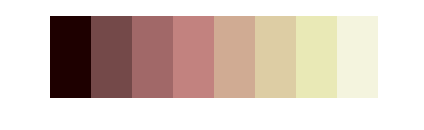

In [56]:
import matplotlib.pyplot as plt
num = 9
gradient = range(num)
for x in range(1):
    gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots(nrows=1)
ax.imshow(gradient, cmap=cmap, interpolation='nearest')
ax.set_axis_off()
fig.tight_layout()

plt.show()
fig.savefig('gradient_data/figures/%s.colorbar.%i.png' % (cmap,num))

## Yeo17 networks

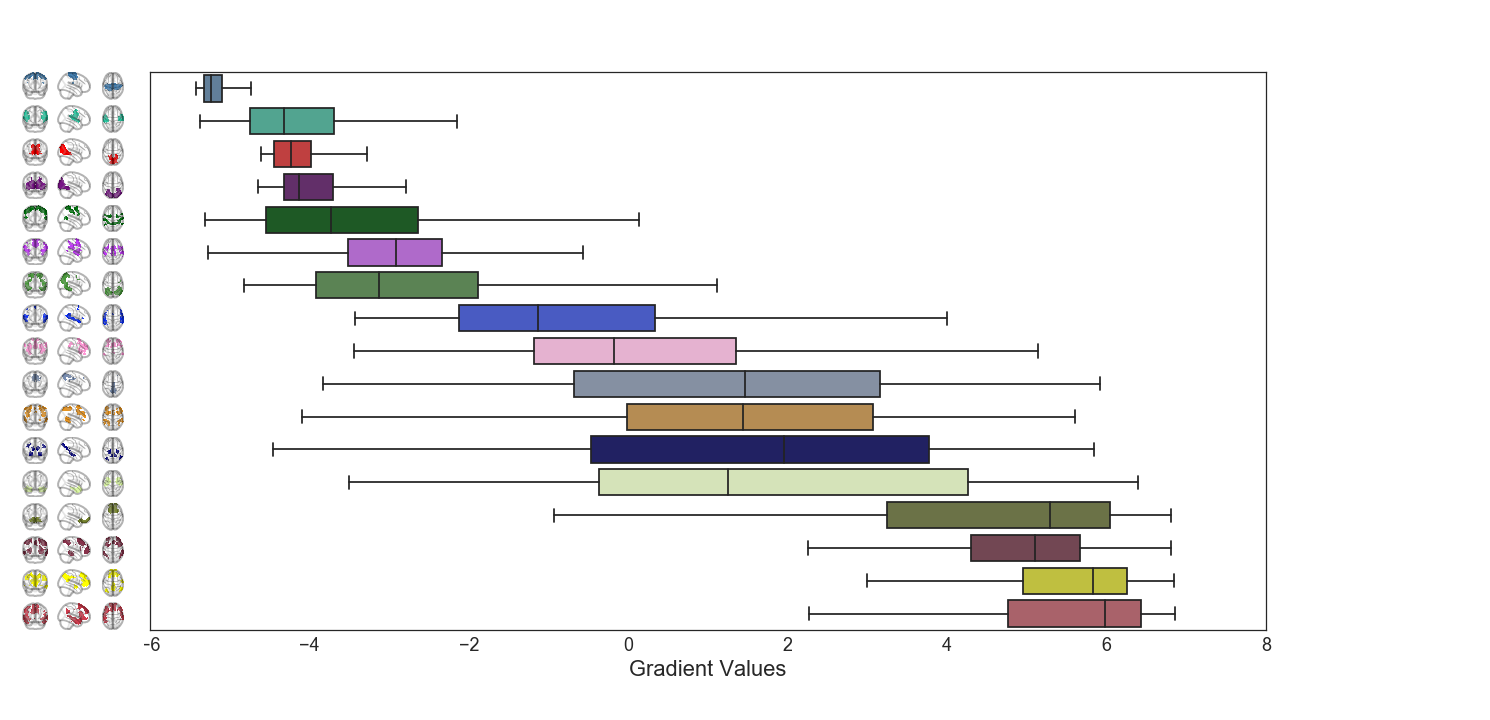

In [41]:
yeo17 = np.concatenate((yeo17L[cortL], yeo17L[cortR]))

uniqueY = np.array(np.unique(yeo17), dtype=np.int32)[1::]
sz = len(uniqueY)

rsns={}
for c in range(sz):
    rsns['k'+str(int(c)+1)]=[]

r = []     
for x in range(sz):
    g = emb[np.where(yeo17 == uniqueY[x])[0],0]
    for y in g:
        if y != 0:
            rsns['k'+str(int(x)+1)].append(float(y))
    r.append(np.mean(rsns['k'+str(int(x)+1)]))

ord = np.argsort(r)

plot_list=[]
for c in range(sz):    
    plot_list+=[np.squeeze(rsns['k'+str(ord[c]+1)])]

names=[]
for c in range(sz):
    names.append(str(int(ord[c])+1))

convertYeo17 = [1,15,5,11,9,4,12,16,14,0,3,8,10,2,7,6,13]

cols17 = ((255,255,255),
        (120,  18, 134 ),
        (255,   0,   0 ),
        (70 ,130, 180  ),
        (42, 204, 164  ),
        (74 ,155 , 60  ),
        (0 ,118,  14  ),
        (196 , 58, 250 ),
        (255 ,152, 213 ),
        (220 ,248, 164 ),
        (122, 135 , 50 ),
        (119 ,140 ,176 ),
        (230 ,148,  34 ),
        (135,  50 , 74 ),
        (12  ,48, 255  ),
        (0 ,  0, 130  ),
        (255, 255,   0 ),
        (205 , 62 , 78 ))

cols = np.asarray(cols17, dtype=np.float64)/255.
yeoCols = ListedColormap(cols,name='colormapYeo')

colors1 = []
for i in xrange(0,len(ord)):
    colors1.append(cols[convertYeo17[ord[i]] + 1])

height=10
sns.set_context('notebook', font_scale=1.8)
sns.axes_style("white")
sns.set_palette(colors1)

fig = plt.figure(figsize=(20,height))
ax = sns.boxplot(data=plot_list, saturation=0.5, orient='h', showfliers=False) #flierprops=dict(marker='+', markersize=2, color="gray", markeredgecolor="gray")
ax.set_yticklabels('')
sns.axlabel('Gradient Values','', fontsize=22)
plt.savefig('gradient_data/figures/yeo17_dist_plot_dist.png')
plt.savefig('gradient_data/figures/yeo17_dist_plot_dist.pdf')
plt.close(fig)

fig, axarr = plt.subplots(nrows=sz, ncols=1, figsize=(2*(20/sz),height))
data = datasets.fetch_atlas_yeo_2011(data_dir='gradient_data/templates/')
yeoV17 = nibabel.load(data.thick_17)
y = 0
for x in range(sz):
    yeoV17_1 = nibabel.Nifti1Image((yeoV17.get_data() == convertYeo17[ord[x]] + 1).astype(int), yeoV17.get_affine()) 
    yeoCols = ListedColormap(cols[[0,convertYeo17[ord[x]] + 1]],name='colormapYeo')
    plotting.plot_glass_brain(yeoV17_1, axes=axarr[x], annotate=False, alpha=0.3, cmap=yeoCols, threshold=0.1, 
                          output_file='gradient_data/figures/yeo17_brains_dist.png')
    y += 1

from PIL import Image
i1 = Image.open('gradient_data/figures/yeo17_dist_plot_dist.png')
i2 = Image.open('gradient_data/figures/yeo17_brains_dist.png')
result = Image.new("RGBA", (np.shape(i1)[1]+50, np.shape(i1)[0]))
result.paste(i1, (-30, 0))
result.paste(i2, (0, 0))
result.save('gradient_data/figures/Yeo17_Fig_dist.png')

from IPython.display import Image as im
im(filename='gradient_data/figures/Yeo17_Fig_dist.png') 

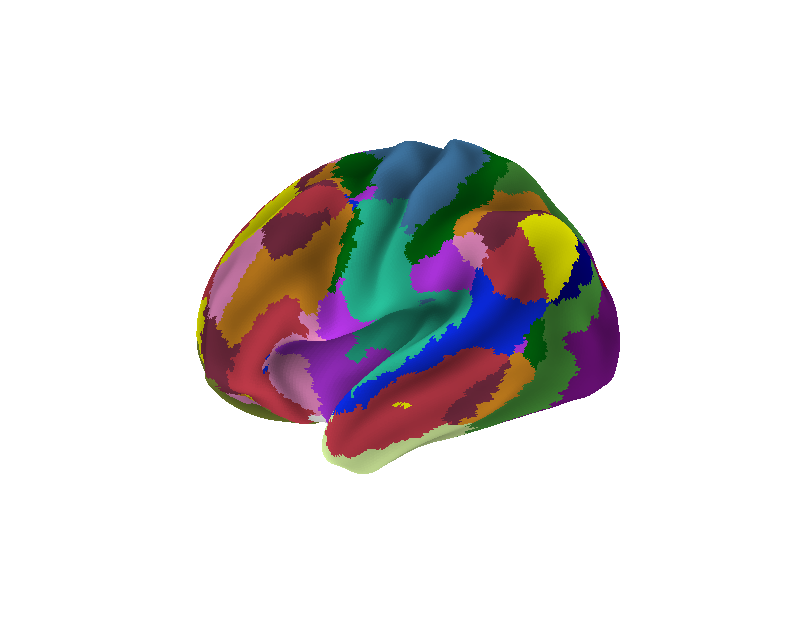

In [64]:
cols17 = ((255,255,255),
        (120,  18, 134 ),
        (255,   0,   0 ),
        (70 ,130, 180  ),
        (42, 204, 164  ),
        (74 ,155 , 60  ),
        (0 ,118,  14  ),
        (196 , 58, 250 ),
        (255 ,152, 213 ),
        (220 ,248, 164 ),
        (122, 135 , 50 ),
        (119 ,140 ,176 ),
        (230 ,148,  34 ),
        (135,  50 , 74 ),
        (12  ,48, 255  ),
        (0 ,  0, 130  ),
        (255, 255,   0 ),
        (205 , 62 , 78 ))

cols = np.asarray(cols17, dtype=np.float64)/255.
yeoCols = ListedColormap(cols,name='colormapYeo')
# use ord to create plot on surface
y = yeo17L.copy()
for n, v in enumerate(uniqueY):
    y[yeo17L == v] = int(convertYeo17[n]) - 8
y[yeo17L == 37] = - 9
c = np.where([yeo17L != 37])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, stat_map=y, bg_on_stat=True, azim=0, alpha=1, cmap=yeoCols, label=True, 
                       bg_scaling_factor=1.5)
plt.show()
f.savefig('gradient_data/figures/yeo17.lat.png')
imageCrop('gradient_data/figures/yeo17.mat.png')
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, mask=c, stat_map=y, bg_on_stat=True, azim=180, alpha=1, cmap=yeoCols, label=True, 
                       bg_scaling_factor=1.5)
plt.show()
f.savefig('gradient_data/figures/yeo17.med.png')
imageCrop('gradient_data/figures/yeo17.med.png')

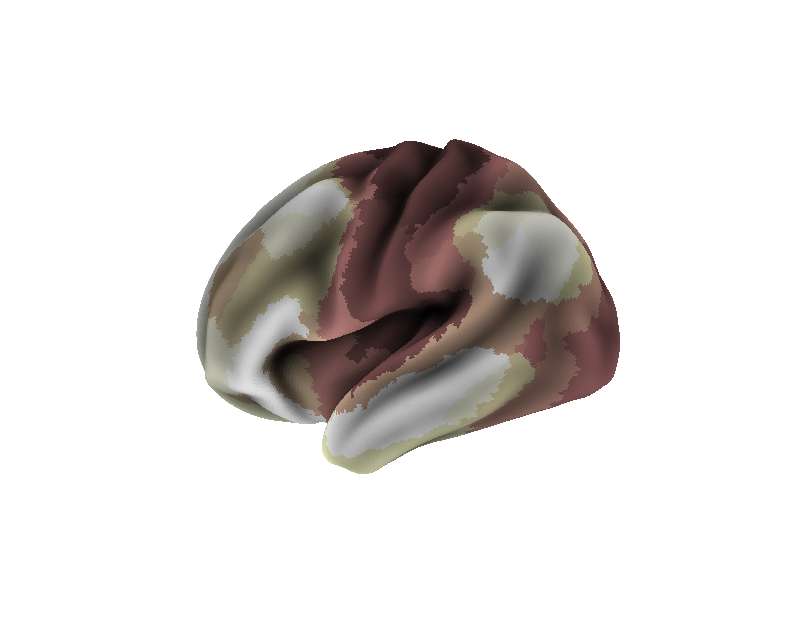

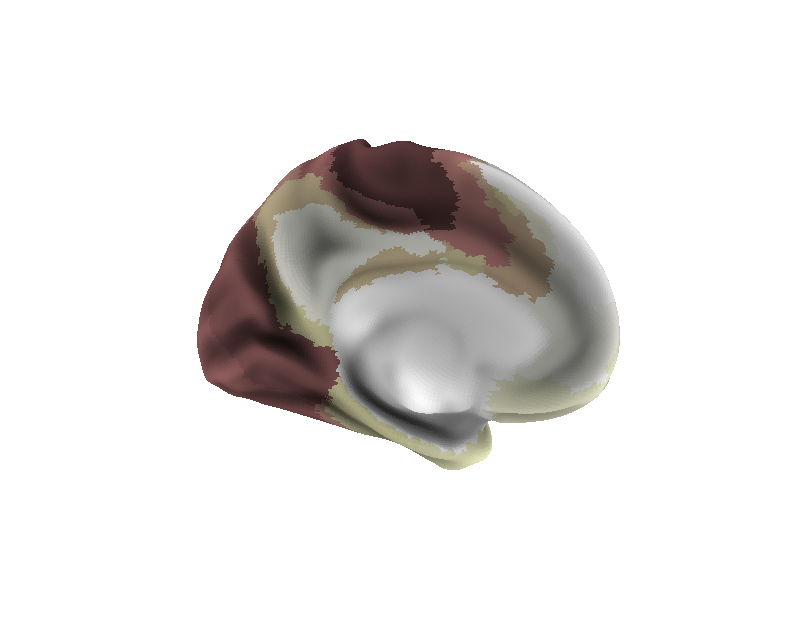

In [40]:
y = yeo17L.copy()
ord1 = np.argsort(ord)
for n, v in enumerate(uniqueY):
    y[yeo17L == v] = int(ord1[n]) + 1 - 8
y[yeo17L == 37] = -8
c = np.where([yeo17L != 37])[1]
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, mask=c, cmap='pink', bg_on_stat=True, azim=0, alpha=1, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo17.reord.lat.png')
f = plot_surf_stat_map(surfL[0], surfL[1], bg_map=sulcL, stat_map=y, mask=c, cmap='pink', bg_on_stat=True, azim=180, alpha=1, label=True)
plt.show()
f.savefig('gradient_data/figures/yeo17.reord.med.png')

# Smith 2009 maps

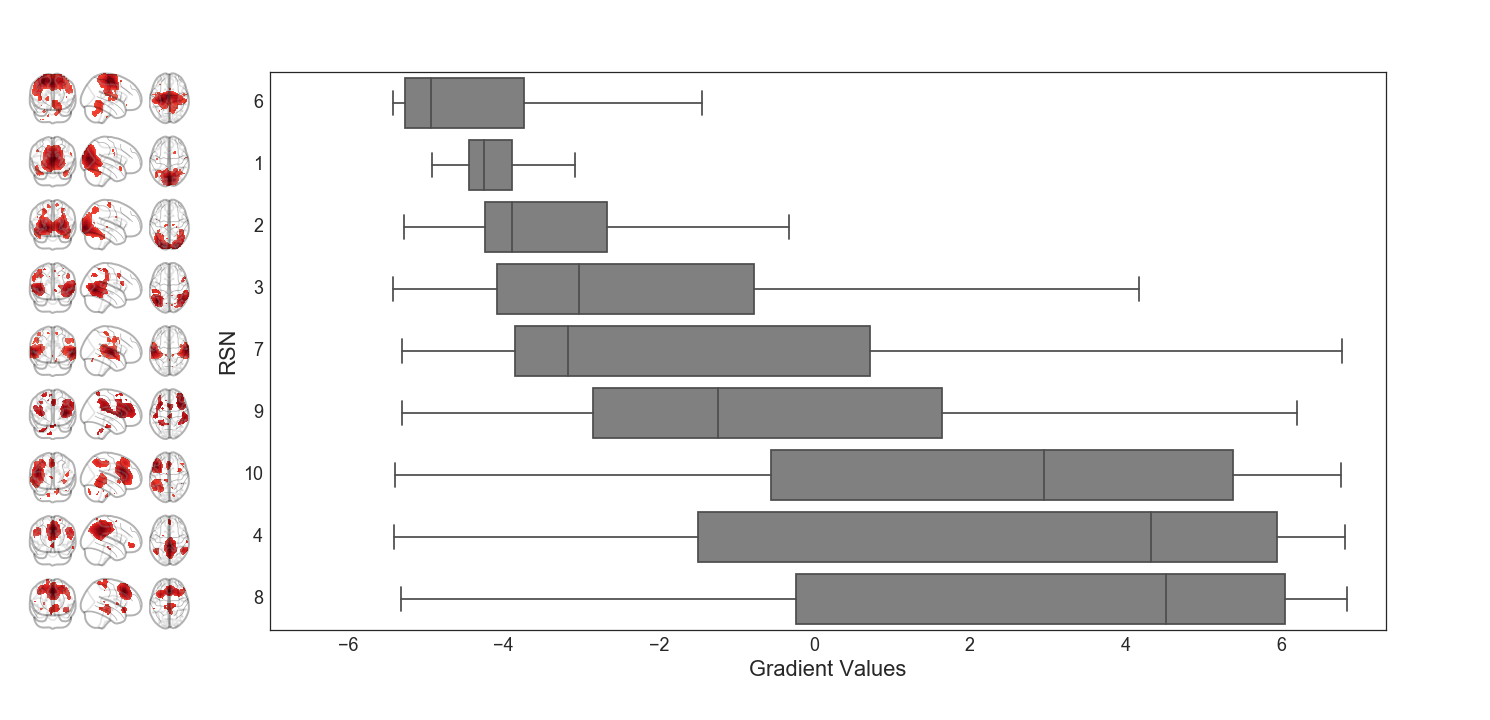

In [113]:
embedS = nib.load('gradient_data/embedded/volumes/volume.cort.0.nii.gz')
e = nib.Nifti1Image(embedS.get_data(), embedS.get_affine())
data = datasets.fetch_atlas_smith_2009(data_dir='gradient_data/templates/')
data_bm10 = nib.load(data.bm10)

thr = 3.1
data_smith = data_bm10
sz = np.shape(data_smith.get_data())[3]

rsns={}
for c in range(sz):
    rsns['k'+str(int(c)+1)]=[]
  
r = []     
for x in range(sz):
    d = nib.Nifti1Image(data_smith.get_data()[:,:,:,x], data_smith.get_affine())   
    g = e.get_data()[np.where((d.get_data() > thr) & (e.get_data() != 0))]    
    for y in g:
        if y != 0:
            rsns['k'+str(int(x)+1)].append(float(y))
    r.append(np.mean(rsns['k'+str(int(x)+1)]))

ord = np.argsort(r)

plot_list=[]
for c in range(sz):
    if data_smith != data_bm10 or ord[c] != 4:
        plot_list+=[np.squeeze(rsns['k'+str(ord[c]+1)])]

names=[]
for c in range(sz):
    if data_smith != data_bm10 or ord[c] != 4:
        names.append(str(int(ord[c])+1))

height=10
sns.set_context('notebook', font_scale=1.8)
fig = plt.figure(figsize=(20,height))

ax = sns.boxplot(data=plot_list, saturation=0.5, color='gray', orient='h', 
                 flierprops=dict(marker='+', markersize=2, color="gray", markeredgecolor="gray"))
ax.set_yticklabels(names)
#ax.set_xlim([np.min(e.get_data()), np.max(e.get_data())])
ax.set_xlim([-7, np.max(e.get_data())+0.5])
sns.axlabel('Gradient Values','RSN', fontsize=22)
plt.savefig('gradient_data/figures/smith_dist_plot.png')
plt.close(fig)
 
# Make smith brains:    
if data_smith == data_bm10:
    fig, axarr = plt.subplots(nrows=sz-1, ncols=1, figsize=(1.5*(20/sz),height))
else:
    fig, axarr = plt.subplots(nrows=sz, ncols=1, figsize=(1.5*(20/sz),height))
    
y = 0
for x in range(sz):
    if data_smith != data_bm10 or ord[x] != 4:
        d = nib.Nifti1Image(data_smith.get_data()[:,:,:,ord[x]], data_smith.get_affine())
        plotting.plot_glass_brain(d, axes=axarr[y], annotate=False, alpha=0.3, threshold=thr, cmap='Reds',
                              output_file='gradient_data/figures/smith_brains.png')
        y += 1

        
from PIL import Image

i1 = Image.open('gradient_data/figures/smith_dist_plot.png')
i2 = Image.open('gradient_data/figures/smith_brains.png')

result = Image.new("RGBA", (np.shape(i1)[1]+50, np.shape(i1)[0]))

result.paste(i1, (90, 0))
result.paste(i2, (0, 0))
result.save('gradient_data/figures/Smith_Fig.png')

from IPython.display import Image as im
im(filename='gradient_data/figures/Smith_Fig.png') 